In [29]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [30]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [31]:
#raw_image_dir="C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/rgb_images"
#label_image_dir="C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/rgbLabels"
raw_image_dir="C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/train_100"
label_image_dir="C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/train_100"
train_dir=raw_image_dir

In [32]:
train_fns = os.listdir(raw_image_dir)
val_fns = os.listdir("C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/val_10")
print(len(train_fns), len(val_fns))

8000 234


In [33]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

transform = T.Resize(size = (256,256))


C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/train_100\05000_RV.png


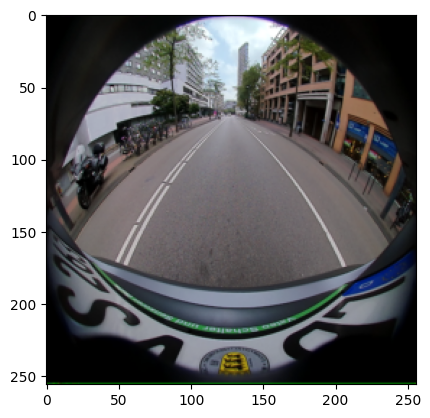

In [34]:
sample_image_fp = os.path.join(train_dir, train_fns[5000])
sample_image = transform(Image.open(sample_image_fp)).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [35]:
train_label_fns = os.listdir(label_image_dir)
val_label_fns = os.listdir("C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/val_10")
print(len(train_label_fns), len(val_label_fns))

8000 234


C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/train_100\05000_RV.png


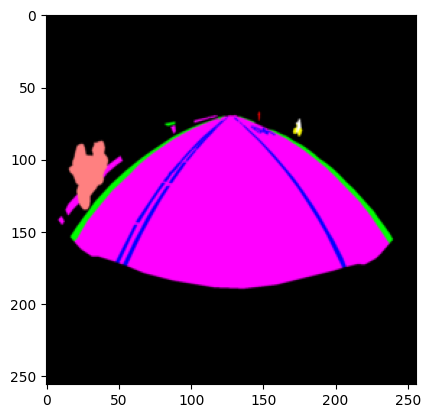

In [36]:
sample_label_fp = os.path.join(label_image_dir, train_label_fns[5000])
sample_label = transform(Image.open(sample_label_fp)).convert("RGB")
plt.imshow(sample_label)
print(sample_label_fp)

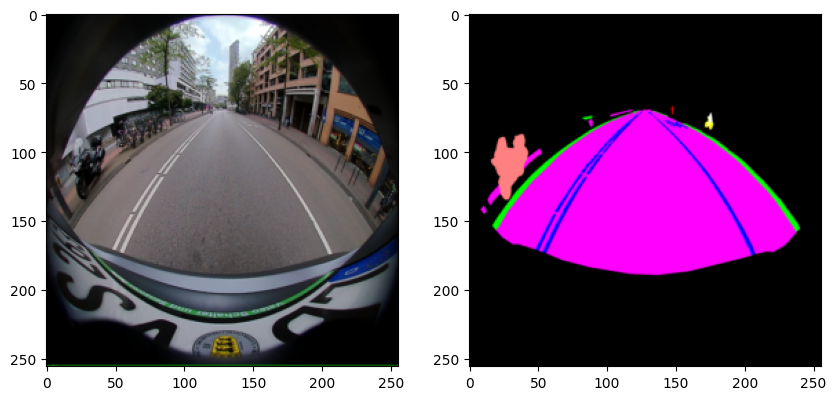

In [37]:

woodscape, label = Image.fromarray(np.array(sample_image)), Image.fromarray(np.array(sample_label))
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(woodscape)
axes[1].imshow(label)

In [42]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [43]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

C:\Users\yashs\Woodscape\woodscape_cuda_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10)

In [ ]:
sample_label = label.convert("RGB")

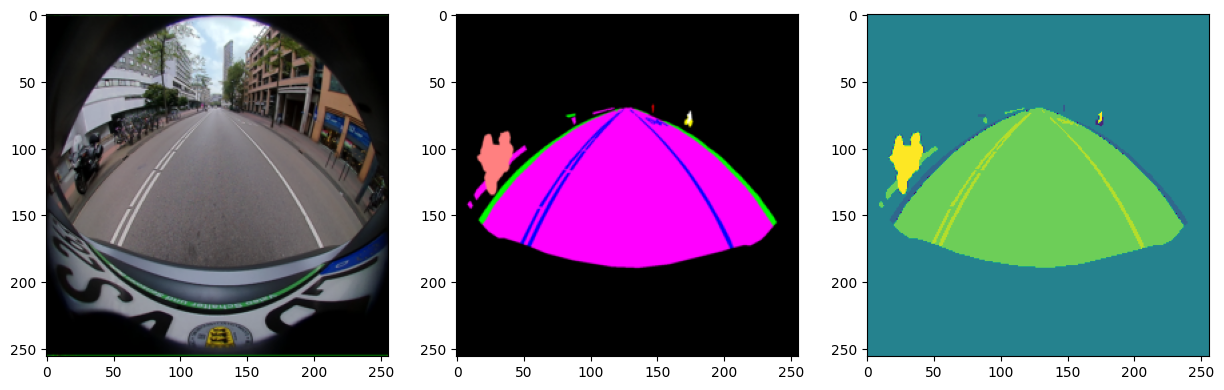

In [45]:
woodscape, label = np.array(sample_image),np.array(sample_label)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(woodscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [46]:
label_class

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]])

In [47]:
class WoodscapeDataset(Dataset):

  def __init__(self, image_dir, label_dir, label_model):
    self.image_dir = image_dir
    self.label_dir = label_dir
    self.image_fns = os.listdir(image_dir)
    self.label_fns = os.listdir(label_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)
  
  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    label_fn = self.label_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    label_fp = os.path.join(self.label_dir, label_fn)
    image = transform(Image.open(image_fp)).convert("RGB")
    label = transform(Image.open(label_fp)).convert("RGB")
    image = np.array(image)
    woodscape = np.array(image)
    label = np.array(label)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    label_class = torch.Tensor(label_class).long()
    woodscape = self.transform(woodscape)
    return woodscape, label_class
  
  def transform(self, image):
    transform_ops = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [48]:
train_dir="C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/train_100"
label_dir="C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/train_100"
dataset = WoodscapeDataset(train_dir,label_dir, label_model)
print(len(dataset))

8000


In [49]:
woodscape, label_class = dataset[0]
print(woodscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


In [50]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [51]:
model = UNet(num_classes=num_classes)

In [24]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).__next__()
print(X.shape, Y.shape)

8000 2000
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [25]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


In [26]:
batch_size = 4
epochs = 35
lr = 0.00001
weight_decay=0.001

In [27]:
dataset = WoodscapeDataset(train_dir,label_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [28]:
model = UNet(num_classes = num_classes).to(device)

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr,weight_decay=weight_decay)

In [27]:
import time
step_losses = []
epoch_losses = []

total_start = time.time()
for epoch in tqdm(range(epochs)):
    epoch_start = time.time()
    print("--------------------- Epoch number: "+str(epoch)+" ---------------------------------")
    epoch_loss = 0
    counter = 0
    for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
        counter=counter+1
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
        if counter%500==0:
            print("step number",counter)
            print("epoch_loss : ",epoch_loss)
            print("step_losses : ",loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))
    epoch_end = time.time()
    print("Epoch Time Taken",epoch_end - epoch_start)
total_end = time.time()
print("Total Time Taken",total_end - total_start)

  0%|          | 0/35 [00:00<?, ?it/s]

--------------------- Epoch number: 0 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  626.770586013794
step_losses :  0.7687606811523438
step number 1000
epoch_loss :  917.8944595754147
step_losses :  0.3485926687717438
step number 1500
epoch_loss :  1120.5898891538382
step_losses :  0.23389165103435516
step number 2000
epoch_loss :  1276.7871036157012
step_losses :  0.2701684832572937
Epoch Time Taken 1196.267118215561
--------------------- Epoch number: 1 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  177.65364326536655
step_losses :  0.2477690875530243
step number 1000
epoch_loss :  332.25173994898796
step_losses :  0.20421409606933594
step number 1500
epoch_loss :  469.8979655355215
step_losses :  0.1574419140815735
step number 2000
epoch_loss :  575.5679850503802
step_losses :  0.18342743813991547
Epoch Time Taken 1207.1178097724915
--------------------- Epoch number: 2 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  138.49196285009384
step_losses :  0.18712127208709717
step number 1000
epoch_loss :  258.88234958052635
step_losses :  0.16922998428344727
step number 1500
epoch_loss :  372.53636940568686
step_losses :  0.1315246820449829
step number 2000
epoch_loss :  457.0649874955416
step_losses :  0.1477205604314804
Epoch Time Taken 1207.3045451641083
--------------------- Epoch number: 3 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  113.87584127485752
step_losses :  0.15850159525871277
step number 1000
epoch_loss :  216.15263578295708
step_losses :  0.1524910181760788
step number 1500
epoch_loss :  313.63742431253195
step_losses :  0.11902179569005966
step number 2000
epoch_loss :  385.58816534280777
step_losses :  0.13449959456920624
Epoch Time Taken 1202.9309072494507
--------------------- Epoch number: 4 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  97.71747453510761
step_losses :  0.14507059752941132
step number 1000
epoch_loss :  185.75181468576193
step_losses :  0.13412708044052124
step number 1500
epoch_loss :  271.3169599175453
step_losses :  0.10849364101886749
step number 2000
epoch_loss :  334.2699344828725
step_losses :  0.12321127951145172
Epoch Time Taken 1201.3429927825928
--------------------- Epoch number: 5 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  86.01775574684143
step_losses :  0.1311768889427185
step number 1000
epoch_loss :  164.5393571332097
step_losses :  0.1398864984512329
step number 1500
epoch_loss :  241.71529445052147
step_losses :  0.10337004065513611
step number 2000
epoch_loss :  297.91650845855474
step_losses :  0.11750978231430054
Epoch Time Taken 1208.6498234272003
--------------------- Epoch number: 6 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  75.93668105453253
step_losses :  0.12251390516757965
step number 1000
epoch_loss :  147.08014634624124
step_losses :  0.1251451075077057
step number 1500
epoch_loss :  217.90051047876477
step_losses :  0.09554444253444672
step number 2000
epoch_loss :  269.6843614503741
step_losses :  0.10491684079170227
Epoch Time Taken 1205.4660737514496
--------------------- Epoch number: 7 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  70.9716589897871
step_losses :  0.11211010068655014
step number 1000
epoch_loss :  136.09059546142817
step_losses :  0.11796363443136215
step number 1500
epoch_loss :  202.936332590878
step_losses :  0.09121103584766388
step number 2000
epoch_loss :  251.28195133060217
step_losses :  0.1035744920372963
Epoch Time Taken 1206.7370977401733
--------------------- Epoch number: 8 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  65.57892963662744
step_losses :  0.1153540089726448
step number 1000
epoch_loss :  128.81941499188542
step_losses :  0.10430916398763657
step number 1500
epoch_loss :  191.68355241790414
step_losses :  0.09168846905231476
step number 2000
epoch_loss :  235.99500505253673
step_losses :  0.09651871770620346
Epoch Time Taken 1210.0609602928162
--------------------- Epoch number: 9 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  60.885701946914196
step_losses :  0.10169602185487747
step number 1000
epoch_loss :  120.81589985638857
step_losses :  0.10786864161491394
step number 1500
epoch_loss :  180.06889888644218
step_losses :  0.08762997388839722
step number 2000
epoch_loss :  222.10757213830948
step_losses :  0.09358073770999908
Epoch Time Taken 1206.2011232376099
--------------------- Epoch number: 10 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  57.108431216329336
step_losses :  0.09669803082942963
step number 1000
epoch_loss :  112.21065011620522
step_losses :  0.10501891374588013
step number 1500
epoch_loss :  168.87600076943636
step_losses :  0.0834151953458786
step number 2000
epoch_loss :  210.05146439000964
step_losses :  0.0912989005446434
Epoch Time Taken 1208.0886816978455
--------------------- Epoch number: 11 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  55.598623767495155
step_losses :  0.09601700305938721
step number 1000
epoch_loss :  108.0935585796833
step_losses :  0.09582710266113281
step number 1500
epoch_loss :  160.94276697561145
step_losses :  0.08309520035982132
step number 2000
epoch_loss :  198.5801404453814
step_losses :  0.08536232262849808
Epoch Time Taken 1204.2725236415863
--------------------- Epoch number: 12 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  51.110892344266176
step_losses :  0.09927143901586533
step number 1000
epoch_loss :  101.93643298000097
step_losses :  0.09759750962257385
step number 1500
epoch_loss :  152.1580407395959
step_losses :  0.0799235925078392
step number 2000
epoch_loss :  187.84499019384384
step_losses :  0.08305700123310089
Epoch Time Taken 1207.370436668396
--------------------- Epoch number: 13 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  56.74971282109618
step_losses :  0.09631232917308807
step number 1000
epoch_loss :  105.91593891382217
step_losses :  0.08642101287841797
step number 1500
epoch_loss :  155.28690467774868
step_losses :  0.07907767593860626
step number 2000
epoch_loss :  190.4450587965548
step_losses :  0.07980579137802124
Epoch Time Taken 1196.4069349765778
--------------------- Epoch number: 14 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  49.026323329657316
step_losses :  0.08654285222291946
step number 1000
epoch_loss :  93.35747984424233
step_losses :  0.0847165510058403
step number 1500
epoch_loss :  139.54890107363462
step_losses :  0.07692276686429977
step number 2000
epoch_loss :  174.25056198239326
step_losses :  0.08250247687101364
Epoch Time Taken 1198.5677425861359
--------------------- Epoch number: 15 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  49.657776940613985
step_losses :  0.08373019099235535
step number 1000
epoch_loss :  93.47685243189335
step_losses :  0.08559268712997437
step number 1500
epoch_loss :  140.06422120332718
step_losses :  0.07858620584011078
step number 2000
epoch_loss :  176.09778791293502
step_losses :  0.07937265932559967
Epoch Time Taken 1199.515507221222
--------------------- Epoch number: 16 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  46.64401660859585
step_losses :  0.08420170843601227
step number 1000
epoch_loss :  89.87745949998498
step_losses :  0.07977466285228729
step number 1500
epoch_loss :  134.61697045713663
step_losses :  0.07308412343263626
step number 2000
epoch_loss :  166.26065212115645
step_losses :  0.07103763520717621
Epoch Time Taken 1198.0651531219482
--------------------- Epoch number: 17 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  42.932797472923994
step_losses :  0.08633944392204285
step number 1000
epoch_loss :  86.37408523261547
step_losses :  0.08807899057865143
step number 1500
epoch_loss :  130.7530595548451
step_losses :  0.07432699203491211
step number 2000
epoch_loss :  161.38006787002087
step_losses :  0.0708044171333313
Epoch Time Taken 1196.004934310913
--------------------- Epoch number: 18 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  41.12683783099055
step_losses :  0.06841304898262024
step number 1000
epoch_loss :  91.062793366611
step_losses :  0.13798600435256958
step number 1500
epoch_loss :  143.386682882905
step_losses :  0.07513856887817383
step number 2000
epoch_loss :  176.23477866128087
step_losses :  0.07899247854948044
Epoch Time Taken 1202.820732831955
--------------------- Epoch number: 19 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  42.23745658993721
step_losses :  0.0716746598482132
step number 1000
epoch_loss :  81.91252155229449
step_losses :  0.08182814717292786
step number 1500
epoch_loss :  123.13592526689172
step_losses :  0.06813859194517136
step number 2000
epoch_loss :  152.24661991000175
step_losses :  0.06714461743831635
Epoch Time Taken 1054.734249830246
--------------------- Epoch number: 20 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  37.91365372762084
step_losses :  0.06169791892170906
step number 1000
epoch_loss :  75.1828207410872
step_losses :  0.07411611080169678
step number 1500
epoch_loss :  115.3339797668159
step_losses :  0.07132038474082947
step number 2000
epoch_loss :  145.14980205520988
step_losses :  0.06500840187072754
Epoch Time Taken 1050.252414226532
--------------------- Epoch number: 21 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  41.57471164688468
step_losses :  0.06821845471858978
step number 1000
epoch_loss :  79.27597409114242
step_losses :  0.0734730064868927
step number 1500
epoch_loss :  119.10207528620958
step_losses :  0.06670486181974411
step number 2000
epoch_loss :  148.4690811559558
step_losses :  0.0604013130068779
Epoch Time Taken 1204.323634147644
--------------------- Epoch number: 22 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  49.16414924710989
step_losses :  0.09436452388763428
step number 1000
epoch_loss :  94.74550220370293
step_losses :  0.07374630868434906
step number 1500
epoch_loss :  134.97752586007118
step_losses :  0.06744392216205597
step number 2000
epoch_loss :  163.80689960345626
step_losses :  0.05868205428123474
Epoch Time Taken 1044.2002506256104
--------------------- Epoch number: 23 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  36.514644995331764
step_losses :  0.060793403536081314
step number 1000
epoch_loss :  71.13731166161597
step_losses :  0.06683778017759323
step number 1500
epoch_loss :  106.45807350613177
step_losses :  0.060944732278585434
step number 2000
epoch_loss :  132.96531948819757
step_losses :  0.055269308388233185
Epoch Time Taken 1058.773401260376
--------------------- Epoch number: 24 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  34.53691241145134
step_losses :  0.06597493588924408
step number 1000
epoch_loss :  71.7939230799675
step_losses :  0.08384617418050766
step number 1500
epoch_loss :  112.70975194871426
step_losses :  0.06630338728427887
step number 2000
epoch_loss :  144.086753802374
step_losses :  0.07164879143238068
Epoch Time Taken 1042.7988576889038
--------------------- Epoch number: 25 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  39.96684738248587
step_losses :  0.060041218996047974
step number 1000
epoch_loss :  76.15776859596372
step_losses :  0.07078976929187775
step number 1500
epoch_loss :  112.17436728999019
step_losses :  0.060572732239961624
step number 2000
epoch_loss :  139.8120968155563
step_losses :  0.05589595437049866
Epoch Time Taken 1040.8302087783813
--------------------- Epoch number: 26 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  34.29519749805331
step_losses :  0.058203551918268204
step number 1000
epoch_loss :  67.96980399824679
step_losses :  0.06524200737476349
step number 1500
epoch_loss :  102.09898235090077
step_losses :  0.05946468934416771
step number 2000
epoch_loss :  131.40992986038327
step_losses :  0.055104732513427734
Epoch Time Taken 1039.1828269958496
--------------------- Epoch number: 27 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  40.70564170181751
step_losses :  0.07951092720031738
step number 1000
epoch_loss :  77.35029891133308
step_losses :  0.06613178551197052
step number 1500
epoch_loss :  114.58485699445009
step_losses :  0.06142865866422653
step number 2000
epoch_loss :  141.0052361022681
step_losses :  0.049502357840538025
Epoch Time Taken 1044.271227836609
--------------------- Epoch number: 28 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  34.170781161636114
step_losses :  0.055012255907058716
step number 1000
epoch_loss :  65.79867972247303
step_losses :  0.05965638905763626
step number 1500
epoch_loss :  98.29945333860815
step_losses :  0.05577860027551651
step number 2000
epoch_loss :  122.83915586769581
step_losses :  0.04638781398534775
Epoch Time Taken 1041.1124322414398
--------------------- Epoch number: 29 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  46.666733127087355
step_losses :  0.07618119567632675
step number 1000
epoch_loss :  84.98447772860527
step_losses :  0.06783109903335571
step number 1500
epoch_loss :  120.30819374322891
step_losses :  0.05906020849943161
step number 2000
epoch_loss :  146.4339780844748
step_losses :  0.048517949879169464
Epoch Time Taken 1040.4601328372955
--------------------- Epoch number: 30 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  33.560585871338844
step_losses :  0.05076493322849274
step number 1000
epoch_loss :  68.12636892870069
step_losses :  0.0787828266620636
step number 1500
epoch_loss :  104.67730787023902
step_losses :  0.05833198130130768
step number 2000
epoch_loss :  129.43281511217356
step_losses :  0.046750277280807495
Epoch Time Taken 1040.7177267074585
--------------------- Epoch number: 31 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  31.79462585784495
step_losses :  0.048780858516693115
step number 1000
epoch_loss :  63.09527792222798
step_losses :  0.06088113784790039
step number 1500
epoch_loss :  95.46904783509672
step_losses :  0.05531066656112671
step number 2000
epoch_loss :  118.86631537973881
step_losses :  0.04085829481482506
Epoch Time Taken 1051.290058374405
--------------------- Epoch number: 32 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  29.931196549907327
step_losses :  0.0464203916490078
step number 1000
epoch_loss :  60.88491499610245
step_losses :  0.12347547709941864
step number 1500
epoch_loss :  95.6130489911884
step_losses :  0.056835755705833435
step number 2000
epoch_loss :  120.19566279835999
step_losses :  0.04725632816553116
Epoch Time Taken 1085.3246502876282
--------------------- Epoch number: 33 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  32.942048855125904
step_losses :  0.05173209309577942
step number 1000
epoch_loss :  74.48005275428295
step_losses :  0.0650411993265152
step number 1500
epoch_loss :  110.03450389951468
step_losses :  0.057262688875198364
step number 2000
epoch_loss :  135.335355123505
step_losses :  0.04662735015153885
Epoch Time Taken 1039.6239914894104
--------------------- Epoch number: 34 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  31.687525387853384
step_losses :  0.04914277046918869
step number 1000
epoch_loss :  61.913727801293135
step_losses :  0.05696575343608856
step number 1500
epoch_loss :  91.82293962687254
step_losses :  0.0495491661131382
step number 2000
epoch_loss :  117.56167844310403
step_losses :  0.05197584629058838
Epoch Time Taken 1040.502878665924
Total Time Taken 39781.62657403946


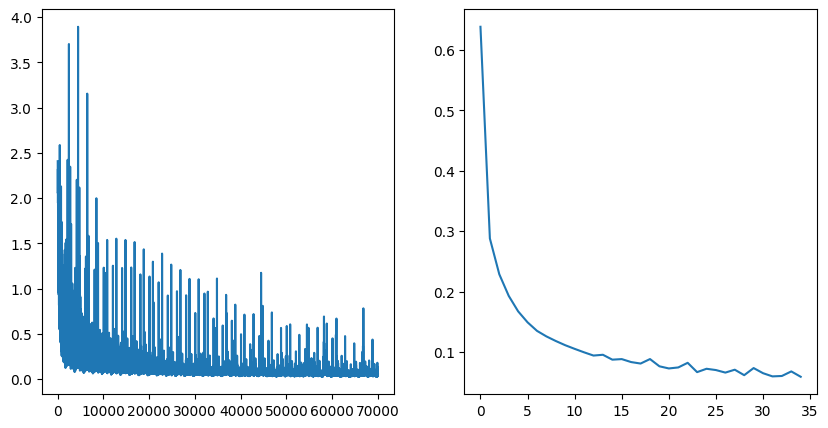

In [33]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(step_losses)
axes[0].set_title("Step Vs Loss")
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Loss')
axes[1].plot(epoch_losses)
axes[1].set_title("Epochs Vs Loss")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')

In [34]:
model_name = "U-Net_8000_v2.pth"
torch.save(model.state_dict(), model_name)

In [54]:
device = "cpu"
device = torch.device(device)
print(device)

cpu


In [55]:
model_path = "U-Net_8000_v2.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [56]:
test_batch_size = 10
val_dir="C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/val_10"
val_label_dir="C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/val_10"
dataset = WoodscapeDataset(val_dir,val_label_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [57]:
import time
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
pred_time_start=time.time()
Y_pred = model_(X)
pred_time_end=time.time()
mean_pred_time=(pred_time_end-pred_time_start)/test_batch_size
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [58]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

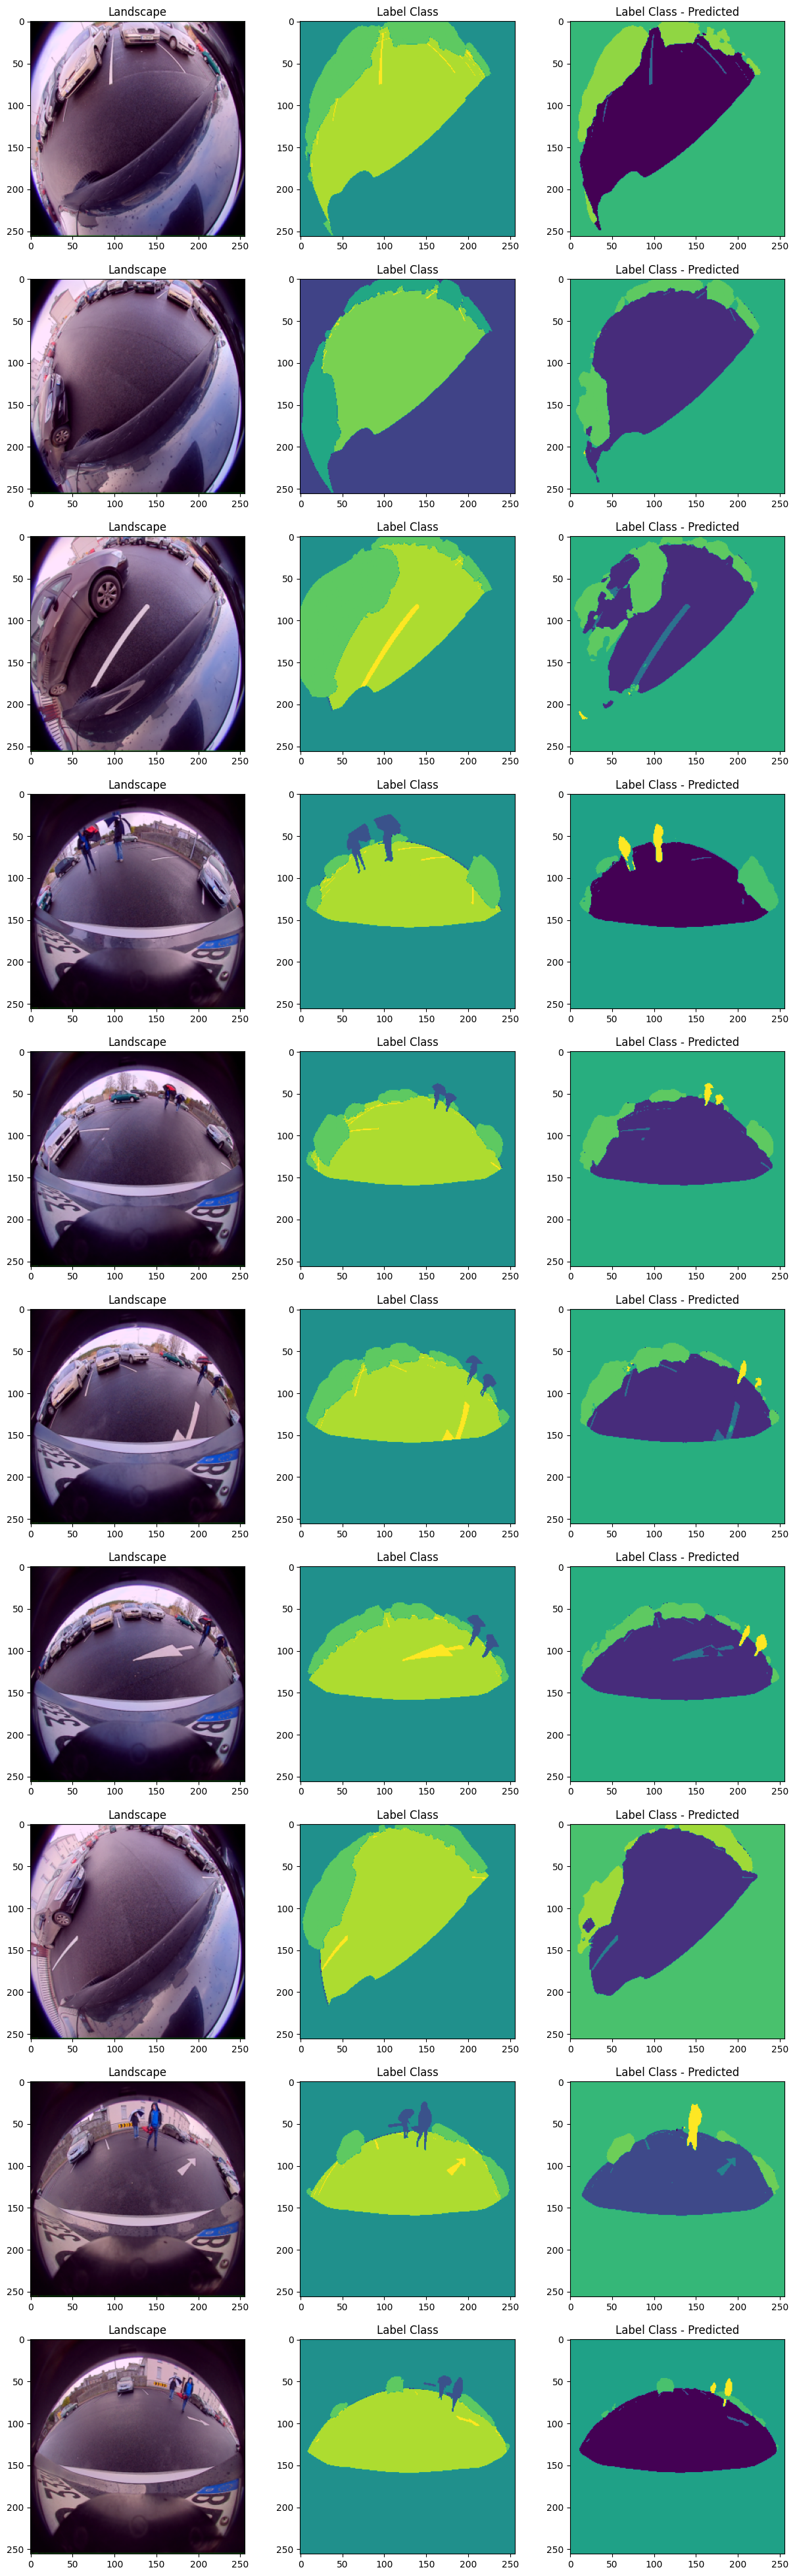

In [59]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [63]:
print("MIOU Score : ",sum(iou_scores) / len(iou_scores))

MIOU Score :  0.7320000000000001


In [64]:
print("Average Prediction Time : ",mean_pred_time)

Average Prediction Time :  0.564781641960144
